# Sheet 2

In [2]:
# Import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import detrend
import scipy.io
import math 
# Import data
data = scipy.io.loadmat("ex2file1.mat")

/var/folders/kq/0f1vjrnj2xn0q3t1270kq05r0000gn/T/ipykernel_16368/4083600694.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [3]:
print(data.keys())

dict_keys(['__header__', '__version__', '__globals__', 'DLPFC1', 'DLPFC2', 'Parietal1', 'Parietal2'])


## Task 1. Univariate AR models

### 1.
**Write down the formula for an AR(4) model and explain how it can be rewritten as a VAR(1) model. Using this, how would you determine an estimate for the parameters $\{a_i\}_{0:4}$? Write down as a formula and compute numerically.**

In [4]:
dlpfc1 = data['DLPFC1']
dlpfc1 = dlpfc1.flatten()

An $AR(4)$ model is of the form
$$x_t = a_0 + \sum_{i = 1}^{4} a_{i} x_{t-i} + \epsilon_t, \quad \epsilon_t \sim W(0,\sigma^2)$$
for $t = 1,...,T$. $x_t$ is stationary, and $W(0,1)$ denotes a white noise distribution with mean $0$ and variance $\sigma^2$.

The time series can writen as the following VAR(1) process.
$$y_t = a + A y_{t-1} + \epsilon_t'$$
Where  $y_t = (x_t, x_{t-1}, x_{t-2}, x_{t-3})^T$, $a = (a_0,0,0,0)^T$, $A = \begin{pmatrix} a_1 & a_2 & a_3 & a_4 \\ 1 & 0 & 0 & 0 \\ 0 & 1 & 0 & 0\\ 0 & 0 & 1 & 0\end{pmatrix}$, $\epsilon_t' = (\epsilon_t, 0,0,0)^T$ 

That the two models are equivalent means that the results we show for one of them can be used for the other. We now use a given time series $y = (x_5,...,x_T)$ and a design matrix $X_p$ to solve the regression problem 
$$ y = XA$$. Here, $X_p$ is the design matrix of dimension $(T-4)$ x $5$ where the first column is ones, the second column $x_4, ..., x_T$, the third $x_3,...,x_{T-1}$ and so on. $x_T$ is the vector of observations, where we discard the first four observations (as we do not have enough preceding observations). We solve minimize the MSE
$$
\text{MSE}(a) = \| y - X_p a \|^2
$$
by taking the derivative and setting it to zero
$$
X_p^T y = X_p^T X_p \hat{a}
$$
the solution for the MSE estimates $\hat{a}$ of $\{a_i\}_{0:4}$ for the AR(4) model (and therefore also the VAR(1) model) are then given by:
$$\hat{a} = (X_p^TX_p)^{-1}X^T_p x_T$$

We calculate the estimates

In [5]:
Xp = np.column_stack([
    np.ones((len(dlpfc1)-4)),  
    dlpfc1[3:-1],
    dlpfc1[2:-2],
    dlpfc1[1:-3],
    dlpfc1[0:-4]
])

a_hat = np.linalg.inv(Xp.T @ Xp) @ (Xp.T @ dlpfc1[4:])
print(np.round(a_hat, 3))

[-0.     1.249 -0.483  0.243 -0.17 ]


### 2.
**Compute the log-likelihood of an AR(4) model. Please write the derivation down explicitly.**

Assuming normality of the residuals the log likelihood of the model is
$$\mathcal{l}(\theta) = \sum_{i=1}^T - \frac{1}{2}\log (2\pi\sigma^2)  - \frac{1}{2}\frac{(x_t - \mu_t)^2}{\sigma^2}$$
Where $\mu_t = \sum_{i = 1}^{4} a_{i} x_{t-i}$. 
In order to compute the log likelihood, we will need estimates of $\mu_t$ and an estimate of $\sigma^2$. We can obtain estimates of $\mu_t$ by using our estimates $a_1, a_2, a_3, a_4$. We do this below

In [6]:
hat_mu_t = [a_hat[0] + np.sum(np.flip(a_hat[1:5]) * dlpfc1[t:(t + 4)]) for t in range(len(dlpfc1)-4)]

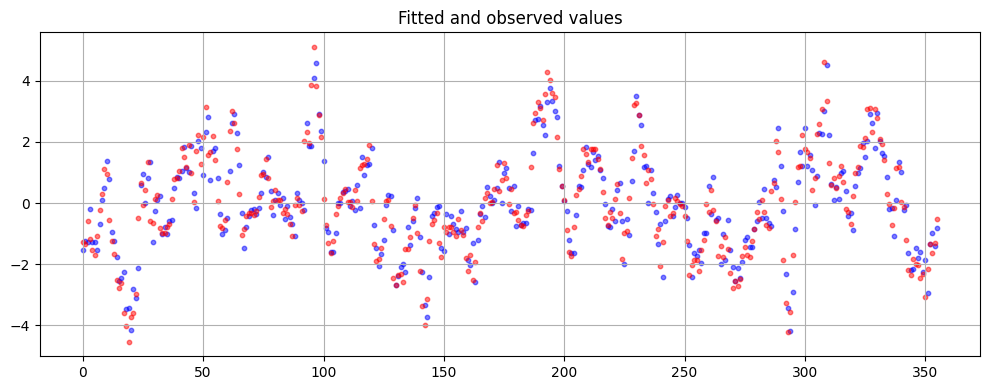

In [7]:
plt.figure(figsize=(10, 4))
plt.scatter(range(0, len(hat_mu_t)), hat_mu_t, color = "blue", s = 10, alpha = 0.5)
plt.scatter(range(0, len(hat_mu_t)), dlpfc1[4:], color = "red", s = 10, alpha=0.5)
plt.title('Fitted and observed values')
plt.grid(True)
plt.tight_layout()
plt.show()

We use the following estimate of $\sigma^2$
$$\hat{\sigma}^2=\frac{1}{T-p} (x_T - \hat{\mu}_t)^T(x_T - \hat{\mu}_t)$$

In [8]:
hat_sigma2 = 1/(len(dlpfc1) - 4) * (dlpfc1[4:] - hat_mu_t) @ (dlpfc1[4:] - hat_mu_t)

Now we can compute the log likelihood estimate

In [9]:
sum(-0.5 * math.log(2 * math.pi * hat_sigma2) - 0.5 * (dlpfc1[4:] - hat_mu_t)*(dlpfc1[4:] - hat_mu_t)/hat_sigma2)

-365.7731931660897

### 3. 
**Plot the residuals of the model in a histogram. What do they look like? What do you expect?**

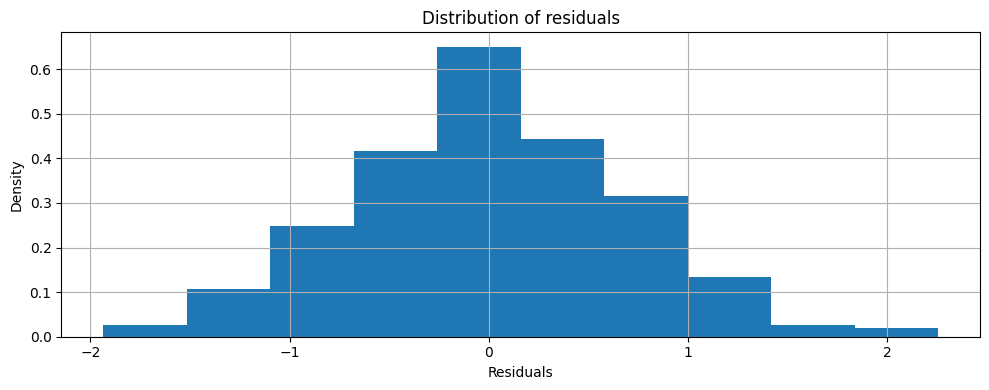

In [10]:
ress = dlpfc1[4:] - hat_mu_t
index = range(len(dlpfc1)-4)

plt.figure(figsize=(10, 4))
plt.hist(ress, density = True)
plt.title('Distribution of residuals')
plt.xlabel('Residuals')
plt.ylabel('Density')
plt.grid(True)
plt.tight_layout()
plt.show()

They look fairly normally distributed, with mean $0$. The mean $0$ is achieved by construction of the model, while the normality assumption is not. It is useful to observe that the residuals indeed satisfy the normality assumption, as this can be used for inference. 

### 4. 
**Compute the log-likelihood of an AR(n) model, with n ranging from 1...5. How does the likelihood change when you increase the order of the model?**

We define the design matrices of the different models

In [14]:
Xp_1 = np.column_stack([
    np.ones((len(dlpfc1)-1)),  
    dlpfc1[0:-1]])
Xp_2 = np.column_stack([
    np.ones((len(dlpfc1)-2)),  
    dlpfc1[1:-1],
    dlpfc1[0:-2]])
Xp_3 = np.column_stack([
    np.ones((len(dlpfc1)-3)), 
    dlpfc1[2:-1],
    dlpfc1[1:-2],
    dlpfc1[0:-3]])
Xp_5 = np.column_stack([
    np.ones((len(dlpfc1)-5)),  
    dlpfc1[4:-1],
    dlpfc1[3:-2],
    dlpfc1[2:-3],
    dlpfc1[1:-4],
    dlpfc1[0:-5]])

We define a function for the calculation of the log likelihood as a function of the design matrices and the order of the process. 

In [19]:
def loglik(des_mat, p):
    est = np.linalg.inv(des_mat.T @ des_mat) @ (des_mat.T @ dlpfc1[p:])
    mu_hat = [est[0] + np.sum(np.flip(est[1:(p+1)]) * dlpfc1[t:(t + p)]) for t in range(len(dlpfc1)-p)]
    sigma2_hat = 1/(len(dlpfc1) - p) * (dlpfc1[p:] - mu_hat) @ (dlpfc1[p:] - mu_hat)
    return(sum(-0.5 * math.log(2 * math.pi * sigma2_hat) - 0.5 * (dlpfc1[p:] - mu_hat) * (dlpfc1[p:] - mu_hat)/sigma2_hat))

We calculate the loglikelihooods

In [21]:
logliks = [loglik(Xp_1, 1), loglik(Xp_2, 2), loglik(Xp_3, 3), loglik(Xp, 4), loglik(Xp_5, 5)]

We plot the log likelihoods

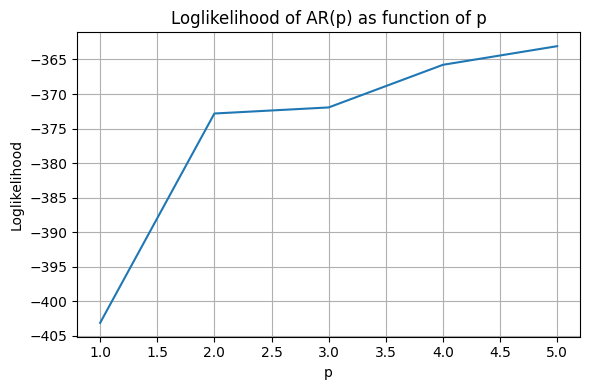

In [24]:
plt.figure(figsize=(6, 4))
plt.plot(range(1,6), logliks)
plt.title('Loglikelihood of AR(p) as function of p')
plt.xlabel('p')
plt.ylabel('Loglikelihood')
plt.grid(True)
plt.tight_layout()
plt.show()

The likelihoood increases as we add parameters to the model, which is to be expected. The more parameters, the more flexible the model is, and the better it can fit data. The likelihood increases quite rapidly at first, and then more moderately, indicating that the more parameters might be overfitting the model. 

### 5.
**Increasing the capacity of the model is likely to increase its explanatory power, but it is important to explore the tradeoff between this and the increase in model parameters. Determine the optimal order p of the AR model by computing the log-likelihood-ratio test statistic. Start with Wilk’s D, which simplifies here to**
$$D = −2[\log \Sigma_p − \log \Sigma_{p−1}]$$
**Plug $D$ into a $\chi^2$ distribution with appropriate degrees of freedom (scipy.stats.chi2.cdf() in Python). Start with the comparison between an AR(2) vs. $AR(1)$ model, and then keep on computing log-likelihood-ratio test statistics for models of consecutive orders up to order $p = 5$, estimating what the best order model is.**

$\Sigma_p$ is here the estimated variance of the residuals. We define a function that will calculate $D$ for us in the following. 

In [ ]:
def Wilsk_D(des_mat1, des_mat2, p1, p2):
    est1 = np.linalg.inv(des_mat1.T @ des_mat1) @ (des_mat1.T @ dlpfc1[p:])
    mu_hat1 = [est1[0] + np.sum(np.flip(est1[1:(p1+1)]) * dlpfc1[t:(t + p1)]) for t in range(len(dlpfc1)-p1)]
    sigma2_hat1 = 1/(len(dlpfc1) - p1) * (dlpfc1[p1:] - mu_hat) @ (dlpfc1[p:] - mu_hat)
    return(- 2 * (np.log(sigma2_hat) - np.log(sigma2_hat)))